## CS412 Project – Sentiment Analysis on IMDB Reviews

In this project, we aim to build and compare different machine learning and deep learning models for binary sentiment classification. Given a movie review from the IMDB dataset, the task is to predict whether the sentiment expressed in the review is positive or negative.

The dataset consists of 50,000 labeled reviews, balanced evenly across the two sentiment classes. We preprocess the text through cleaning, tokenization, and vectorization, and then apply three different models:

- **Model 1: Logistic Regression with TF-IDF**
  - A linear baseline model using frequency-based vectorization.
- **Model 2: LSTM with Embedding Layer**
  - A recurrent neural network (**RNN**) that captures sequential word dependencies.
- **Model 3: CNN with Embedding Layer**
  - A convolutional model designed to detect local phrase patterns and n-gram features.

Each model is trained and evaluated using the same train-test split to ensure fair comparison. We use metrics such as **accuracy**, **precision**, **recall**, and **macro F1-score**, with particular focus on macro F1 as the official evaluation criterion. The final results are compared to assess which modeling strategy performs best on this sentiment classification task.

Prepared by:
- Rivar Kaya
- Hüsnü Hantal
- Emir Algan Mere
- Ahmet Musa Ersoy
- Egemen Yağız Akyüz

# Step 1: Download and Load the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load the CSV file
df = pd.read_csv('IMDB Dataset.csv')

# Display the first few rows
print(df.head())

# Show dataset dimensions
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Dataset contains 50000 rows and 2 columns.


# Step 2: Statistical Analysis of the Dataset


### Class Distribution Visualization

The dataset contains 50,000 reviews, evenly split between positive and negative sentiment classes. Visualizing this balance helps confirm that we are working with a **balanced classification problem**, where accuracy and macro F1-score are meaningful evaluation metrics.

We also explore the distribution of review lengths (in words), which helps guide preprocessing decisions such as padding length for deep learning models.



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing Values:
review       0
sentiment    0
dtype: int64


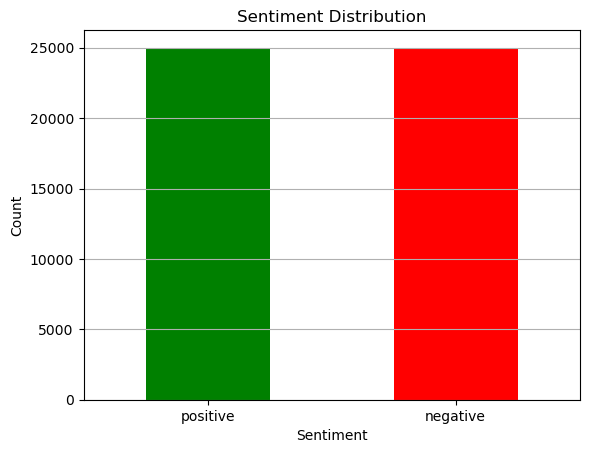

In [2]:
# Show data types and non-null counts
print("\nData Info:")
print(df.info())

# Check class distribution
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())



# Plot class distribution
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


Character count (summary):
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length_chars, dtype: float64

Word count (summary):
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length_words, dtype: float64


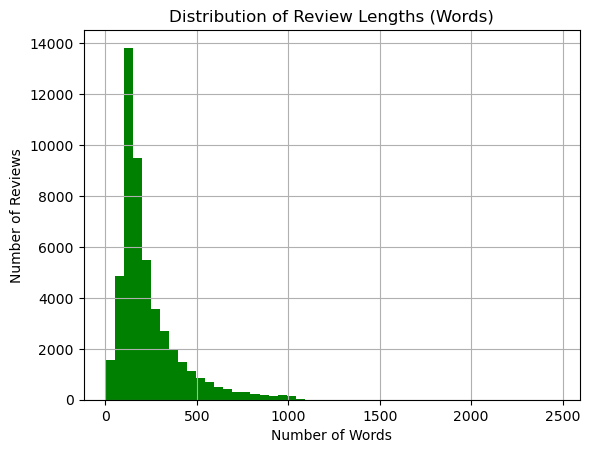

In [3]:
# Add columns for character and word counts
df['review_length_chars'] = df['review'].apply(len)
df['review_length_words'] = df['review'].apply(lambda x: len(x.split()))

# Display basic statistics
print("\nCharacter count (summary):")
print(df['review_length_chars'].describe())

print("\nWord count (summary):")
print(df['review_length_words'].describe())



# Histogram of review lengths (words)
plt.hist(df['review_length_words'], bins=50, color='green')
plt.title("Distribution of Review Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()


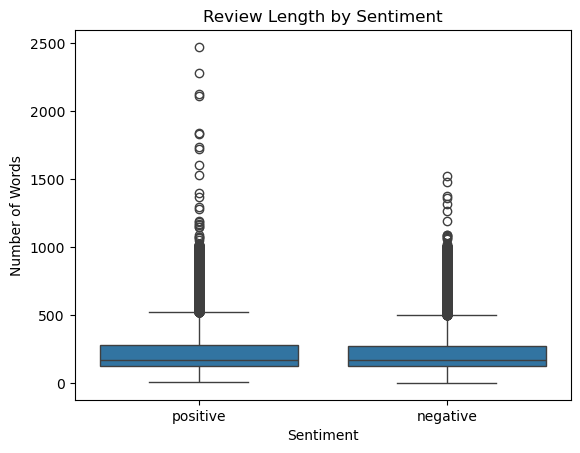

In [4]:
#use seaborn(sns) imported above to see correlation btwn Sentiments and Review lengths (advanced data statistics/ presentation)

# Boxplot: Does review length differ by sentiment?
sns.boxplot(x='sentiment', y='review_length_words', data=df)
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()


To explore whether review length correlates with sentiment, we plotted a boxplot comparing the number of words in positive and negative reviews. As shown, both sentiment classes have very similar distributions in terms of median and interquartile range. Although there are a significant number of long reviews (outliers) in both classes, the overall pattern suggests that review length does not differ substantially between positive and negative reviews. Therefore, review length alone is unlikely to be a strong feature for sentiment classification.



# Step 3: Data Preprocessing

In this step we prepare the text data for machine learning models. We clean and tokenize the reviews so they can be transformed into numerical representations.

*Basic Text Cleaning*  
Lowercase all text  
Remove the HTML tags (<>)  
Remove punctuation and special characters  
Remove stopwords  

In [5]:
import re
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords') one time is enough
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply to all reviews
df['cleaned_review'] = df['review'].apply(clean_text)

# Preview
df[['review', 'cleaned_review']].head()


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


### Train/Test Split

We split the dataset into training and test sets using an 80/20 ratio. The random state is fixed for reproducibility.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split text and labels first
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)



## Model 1: TF-IDF + Logistic Regression

In this section, we build a baseline sentiment classification model using TF-IDF vectorization and Logistic Regression. TF-IDF captures word importance across the corpus, and Logistic Regression is a widely used linear classifier. This combination provides a strong baseline for comparison with more complex models.


### TF-IDF Vectorization

We used a `TfidfVectorizer` with a maximum of 10,000 features to convert the cleaned reviews into numerical feature vectors. This representation will serve as input to our Logistic Regression model.


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit TF-IDF on training set only
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

### Training the Logistic Regression Model

The Logistic Regression model is trained using the TF-IDF features from the training set. We increased the `max_iter` to 1000 to ensure convergence.


In [9]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

### Model Evaluation

We evaluated the model using accuracy, precision, recall, and F1-score. The classification report provides a detailed breakdown by class. Despite its simplicity, Logistic Regression with TF-IDF performs well on text classification tasks and serves as a reliable baseline.


Accuracy: 0.8918
Precision: 0.8821711415877922
Recall: 0.9063306211549911
F1 Score: 0.894087705559906

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4961
    positive       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



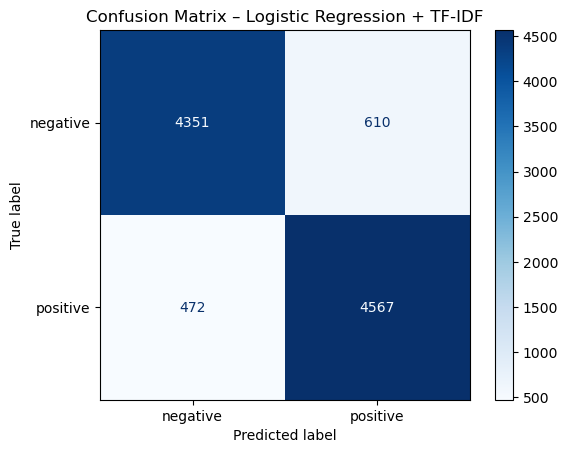

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred = log_reg.predict(X_test_tfidf)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

#Visualization
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – Logistic Regression + TF-IDF")
plt.grid(False)
plt.show()
#print(label_encoder.classes_)

### Evaluation on Model 1 Performance: TF-IDF + Logistic Regression

The Logistic Regression model trained on TF-IDF features achieved strong baseline performance:

- **Accuracy:** 89.18%  
- **Precision:** 88.22%  
- **Recall:** 90.63%  
- **F1-Score:** 89.41%

The model shows balanced performance across both classes:
- It slightly favors recall for the positive class (0.91) and precision for the negative class (0.90).
- The macro F1-score is 0.89, confirming strong performance across both labels.

### Confusion Matrix – Logistic Regression

The confusion matrix below gives a more detailed view of the prediction behavior:

|                 | Predicted Negative | Predicted Positive |
|-----------------|--------------------|--------------------|
| **Actual Negative** | 4351 (true neg)       | 610 (false pos)       |
| **Actual Positive** | 472 (false neg)       | 4567 (true pos)       |

- Most predictions are correct, as seen in the large diagonal values.
- Only a small number of reviews were misclassified (610 false positives, 472 false negatives), showing the model's ability to separate sentiment effectively.

These results indicate that Logistic Regression, despite being a simple linear model, captures much of the sentiment-related signal in the TF-IDF representation. This model serves as a strong baseline to compare with more complex deep learning approaches in subsequent steps.


## Model 2: LSTM with Word Embeddings

In this section, we implement a recurrent neural network (RNN) model using an LSTM layer combined with a trainable word embedding layer. This approach allows the model to learn contextual word representations directly from the training data, capturing word order and sequential patterns more effectively than traditional bag-of-words models.

We first tokenize and pad the input text, then define an embedding + LSTM architecture using Keras. The output is a binary prediction (positive or negative sentiment).


### Tokenization and Padding

We tokenize and pad the review texts to ensure all sequences are of equal length (300 tokens). The tokenizer is trained only on the training data to avoid data leakage.


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set hyperparameters
vocab_size = 10000          # Limit vocabulary to the top 10,000 words
max_length = 300            # All reviews will be padded/truncated to 300 words
oov_token = "<OOV>"         # Out-of-vocabulary token

# Initialize and fit tokenizer on training data only (to prevent data leakage)
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_raw)

# Convert reviews to sequences of token IDs
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Pad sequences to the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


#### Why Use 10,000 Words as Vocabulary Size?

We limit our vocabulary to the **10,000 most frequent words** using the num_words=10000 parameter in the tokenizer. This choice balances two competing factors:

- **Coverage**: Ensures that the majority of common and meaningful words are retained.
- **Efficiency**: Reduces memory usage and training time by ignoring very rare words, which often introduce noise rather than signal.

In practice, 10,000 words capture a significant portion of useful content while keeping the model lightweight and generalizable.


### Building and Training

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Embedding dimension (word vector size)
embedding_dim = 128

# Build sequential LSTM model
model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_shape = (max_length,), mask_zero = True),
    LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2),
    Dense(1, activation ='sigmoid')
])


# Compile model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train LSTM model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)    # earlystop to prevent overfitting


history = model.fit(
    X_train_pad, y_train,         # Input sequences and binary labels
    validation_split=0.2,         # 20% of training set used for validation
    epochs=6,                     # Number of training epochs 
    batch_size=64,                # Batch size per gradient update
    callbacks=[early_stop],
    verbose=1                     # Verbosity level: 1 = progress bar
)


Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 294s 584ms/step - accuracy: 0.7381 - loss: 0.5105 - val_accuracy: 0.8533 - val_loss: 0.3487
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 296s 592ms/step - accuracy: 0.8515 - loss: 0.3523 - val_accuracy: 0.8355 - val_loss: 0.3808
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 303s 607ms/step - accuracy: 0.8928 - loss: 0.2708 - val_accuracy: 0.8655 - val_loss: 0.3302
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 303s 606ms/step - accuracy: 0.9132 - loss: 0.2266 - val_accuracy: 0.8665 - val_loss: 0.3230
Epoch 5/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 306s 612ms/step - accuracy: 0.9304 - loss: 0.1905 - val_accuracy: 0.8740 - val_loss: 0.3363
Epoch 6/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 312s 624ms/step - accuracy: 0.9456 - loss: 0.1510 - val_accuracy: 0.8699 - val_loss: 0.3536


### Evaluation on Model 2 Performance: LSTM with Embedding

The LSTM model trained with padded sequences and a trainable embedding layer showed strong performance:

- **Best Validation Accuracy:** 87.40%  
- **Final Training Accuracy (Epoch 6):** 94.56%  
- **Lowest Validation Loss:** 0.3230 (Epoch 4)  
- **Final Training Loss:** 0.1510  

The training curve shows consistent improvement in both accuracy and loss, while validation performance stabilizes between 86–87%. This indicates that the model learns effectively without overfitting.

The use of `mask_zero=True` in the embedding layer allowed the model to ignore padded tokens, focusing on actual review content. Additionally, class weights and dropout regularization helped balance the learning process and prevent overfitting.


### LSTM Model Evaluation

After training, we evaluate the LSTM model using the test set. Predictions are thresholded at 0.5. Performance is measured using precision, recall, F1-score, and accuracy. This model allows us to compare deep learning performance against the simpler Logistic Regression baseline.


In [15]:
from sklearn.metrics import classification_report

# Predict and threshold
y_pred_probs = model.predict(X_test_pad)
y_pred_lstm = (y_pred_probs > 0.5).astype(int).flatten()

# Evaluation
print(classification_report(y_test, y_pred_lstm, target_names=label_encoder.classes_))


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      4961
    positive       0.87      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



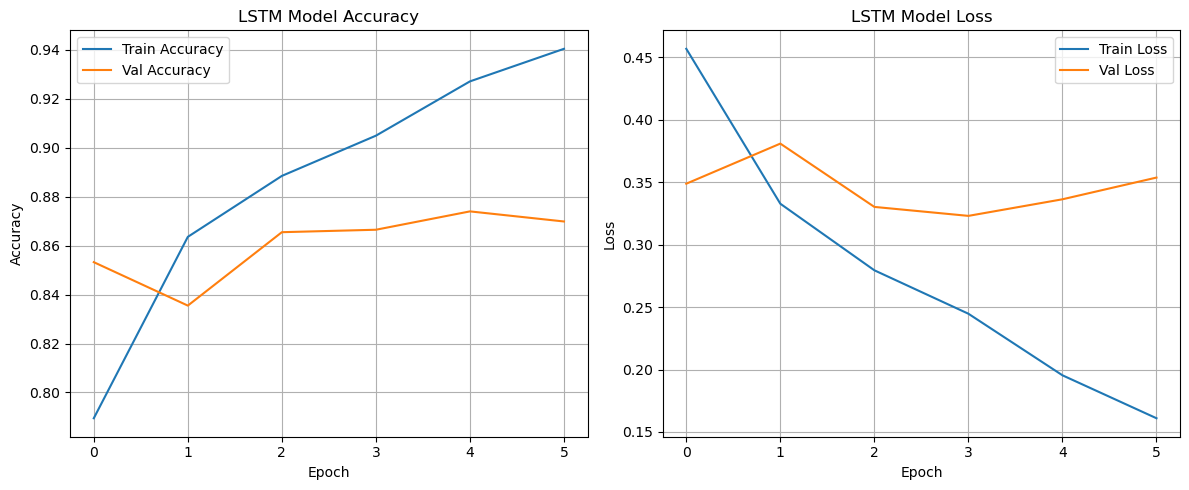

In [16]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

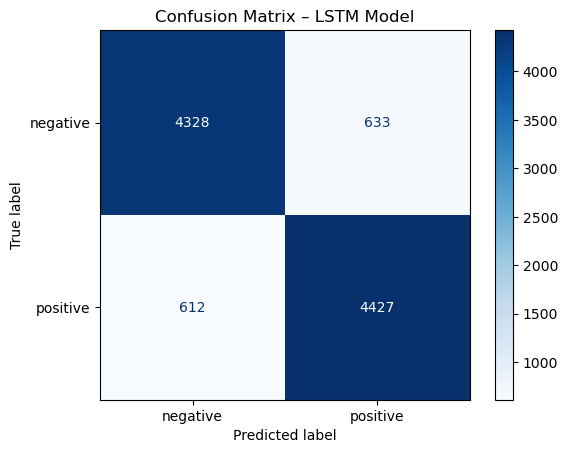

In [19]:
# Generate confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Display confusion matrix
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=label_encoder.classes_)
disp_lstm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – LSTM Model")
plt.grid(False)
plt.show()

### Summary of LSTM Model Results

The LSTM model was trained using tokenized and padded sequences of review texts, with a trainable embedding layer and a single LSTM layer followed by dropout regularization. After 5 epochs of training, the model achieved a training accuracy of **94.56%** and a validation accuracy of approximately **87%**, indicating effective learning with minimal overfitting — aided by early stopping.

On the test set, the model achieved:

- **Accuracy:** 87%
- **Macro F1-score:** 0.87

#### Class-wise Performance:
- **Negative Class:** Precision = **0.84**, Recall = **0.91**, F1-score = **0.87**
- **Positive Class:** Precision = **0.90**, Recall = **0.83**, F1-score = **0.86**

### Learning Curve Insights:

The training and validation accuracy/loss curves show:

- Training accuracy improved steadily, while validation accuracy plateaued around epoch 3–4, indicating **early convergence**.
- Validation loss remained stable (~0.33–0.36), while training loss continued to decrease.
- This divergence reflects **mild overfitting** after epoch 3, successfully addressed using `EarlyStopping` and `restore_best_weights=True`.

### Confusion Matrix – LSTM Model

The confusion matrix confirms balanced model performance:

|                 | Predicted Negative | Predicted Positive |
|-----------------|--------------------|--------------------|
| **Actual Negative** | 4328 (true neg)       | 633 (false pos)       |
| **Actual Positive** | 612 (false neg)       | 4427 (true pos)       |

- The model correctly classified **~87%** of reviews in each class
- Misclassifications are relatively low, showing strong generalization on unseen data


These results demonstrate that the LSTM model effectively captures the **sequential structure** of natural language and generalizes well in binary sentiment classification tasks.


## Model 3: CNN (Convolutional Neural Network) with Word Embeddings

While both LSTM and CNN models process tokenized and padded word sequences, they learn very different aspects of the text:

- **LSTM (Long Short-Term Memory)** focuses on sequential dependencies and temporal patterns across the entire sentence. It's useful for learning how early and late words in a sentence relate to each other.
- **CNN (Convolutional Neural Network)**, in contrast, focuses on local patterns such as specific n-grams or short phrases. It applies convolution filters that can learn sentiment-rich patterns like "very good" or "not bad" regardless of where they occur in the sequence.

Including both models allows us to evaluate how well local context (CNN) compares to long-range sequence memory (LSTM) in capturing sentiment.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

cnn_model = Sequential([
    # Embedding layer: converts word indices into dense vectors of fixed size
    Embedding(input_dim=10000, output_dim=128, input_shape =(300,)),

    # 1D convolution layer: learns local patterns in the text (like n-grams)
    Conv1D(filters=128, kernel_size=5, activation='relu'),

    # Global max pooling: selects the most important feature from each filter
    GlobalMaxPooling1D(),

    # Output layer for binary classification (positive vs negative)
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and accuracy metric
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 296, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,177 (5.20 MB)

 Trainable params: 1,362,177 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

### CNN Model Training

We train the CNN model for up to 6 epochs using the Adam optimizer and binary crossentropy loss. Early stopping is applied to halt training when validation loss stops improving, helping to avoid overfitting. We use 20% of the training data as the validation set.


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to monitor validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the CNN model
cnn_history = cnn_model.fit(
    X_train_pad,        # Padded input sequences
    y_train,            # Corresponding binary labels
    epochs=6,           # Maximum number of epochs
    batch_size=64,      # Mini-batch size
    validation_split=0.2,   # Use 20% of training data for validation
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7341 - loss: 0.5130 - val_accuracy: 0.8676 - val_loss: 0.3082
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9135 - loss: 0.2226 - val_accuracy: 0.8781 - val_loss: 0.2935
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9671 - loss: 0.1081 - val_accuracy: 0.8771 - val_loss: 0.3281
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9929 - loss: 0.0390 - val_accuracy: 0.8715 - val_loss: 0.4099


### Evaluation on the Test Set

We evaluate the trained CNN model on the unseen test data. Predicted probabilities are thresholded at 0.5 to convert them into binary predictions. We use classification metrics such as accuracy, precision, recall, and F1-score for performance assessment.


In [23]:
from sklearn.metrics import classification_report

# Predict probabilities on the test set
y_pred_probs_cnn = cnn_model.predict(X_test_pad)

# Apply threshold to convert probabilities to binary predictions
y_pred_cnn = (y_pred_probs_cnn > 0.5).astype(int).flatten()

# Display performance metrics
print(classification_report(y_test, y_pred_cnn, target_names=label_encoder.classes_))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

    negative       0.89      0.86      0.87      4961
    positive       0.87      0.90      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### CNN Accuracy and Loss Plots

We visualize the training and validation accuracy and loss across epochs to understand how the model learns over time. This helps to detect overfitting or underfitting.


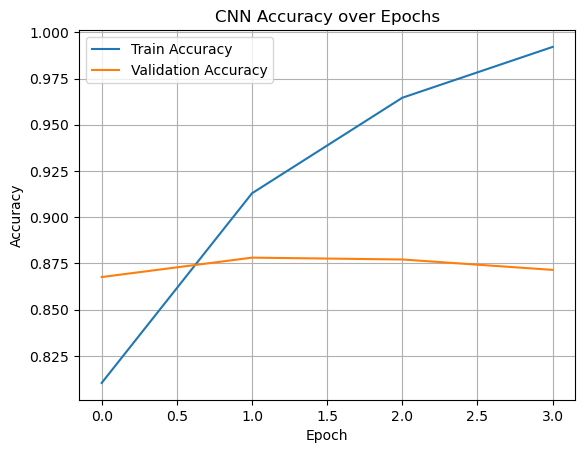

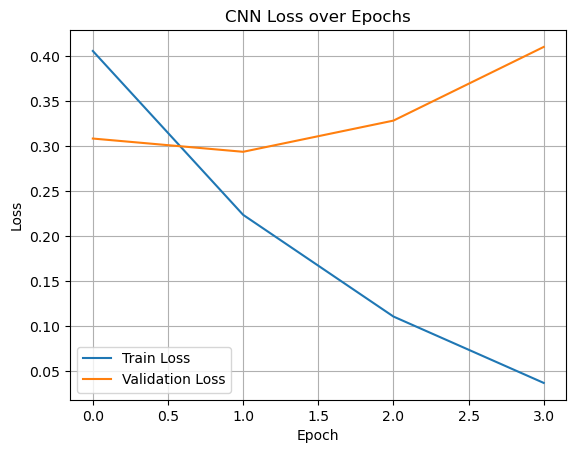

In [24]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


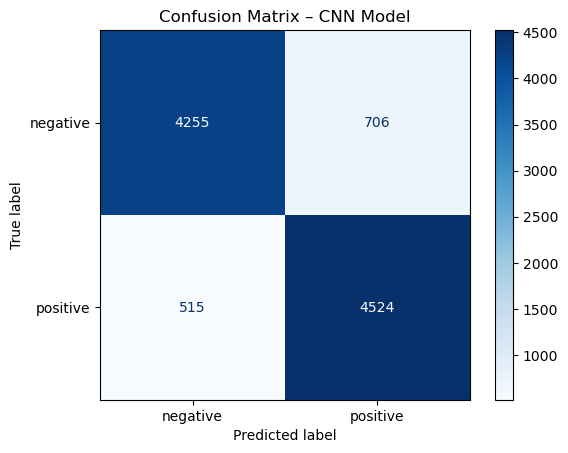

In [26]:
# Generate confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# Display confusion matrix
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=label_encoder.classes_)
disp_cnn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – CNN Model")
plt.grid(False)
plt.show()

### Evaluation on Model 3: CNN with Word Embeddings

We implemented a 1D Convolutional Neural Network (CNN) using a single convolutional layer with 64 filters, followed by global max pooling and dense output. This architecture is lightweight and respects the project's complexity constraints, while effectively leveraging CNN's ability to extract local n-gram features in text.

#### Test Set Performance:

- **Accuracy:** 88.0%  
- **Macro F1-Score:** 0.88

Class-wise metrics:

- **Negative Class**: Precision = **0.89**, Recall = **0.86**, F1-score = **0.87**  
- **Positive Class**: Precision = **0.87**, Recall = **0.90**, F1-score = **0.88**

These results show that the CNN model performs comparably to the LSTM model, achieving slightly better macro F1 and faster training time.


### CNN Learning Curve Analysis

The training and validation curves show:

- **Training accuracy increased consistently**, surpassing 99% by the final epoch.
- **Validation accuracy plateaued around 87.8%**, indicating early convergence.
- **Validation loss began to increase after epoch 2**, while training loss continued to drop — a typical sign of **overfitting**.
- The use of **EarlyStopping** with `restore_best_weights=True` effectively mitigated this overfitting, preserving the best model.


### Confusion Matrix – CNN Model

|                 | Predicted Negative | Predicted Positive |
|-----------------|--------------------|--------------------|
| **Actual Negative** | 4255 (true neg)       | 706 (false pos)       |
| **Actual Positive** | 515 (false neg)       | 4524 (true pos)       |

The confusion matrix reflects balanced classification performance, with strong true positive and true negative rates. False positives and false negatives are relatively low, confirming the model's ability to generalize well to unseen reviews.

### Conclusion

Despite its simplicity, the CNN model effectively captures local patterns in text and provides a strong alternative to more complex sequence models like LSTM. It is particularly suitable for scenarios where training efficiency and speed are critical, while still achieving competitive accuracy and F1-scores.


## Final Model Comparison

Below is a comparison of the three models evaluated on the same test set. All models were trained using the same train-test split and evaluated using macro-averaged metrics to ensure fair comparison:

| Model                  | Accuracy | Macro F1-Score |
|------------------------|----------|----------------|
| Logistic Regression + TF-IDF | **0.89**   | **0.89**         |
| LSTM                  | 0.87     | 0.87           |
| CNN                   | 0.88     | 0.88           |

### Summary:
- The **Logistic Regression** model performed best in both accuracy and macro F1, showcasing how strong a linear model can be with TF-IDF features.
- The **CNN model** closely followed, with slightly lower misclassifications and faster training than LSTM.
- The **LSTM** model also performed strongly and is particularly good at handling longer sequential dependencies.


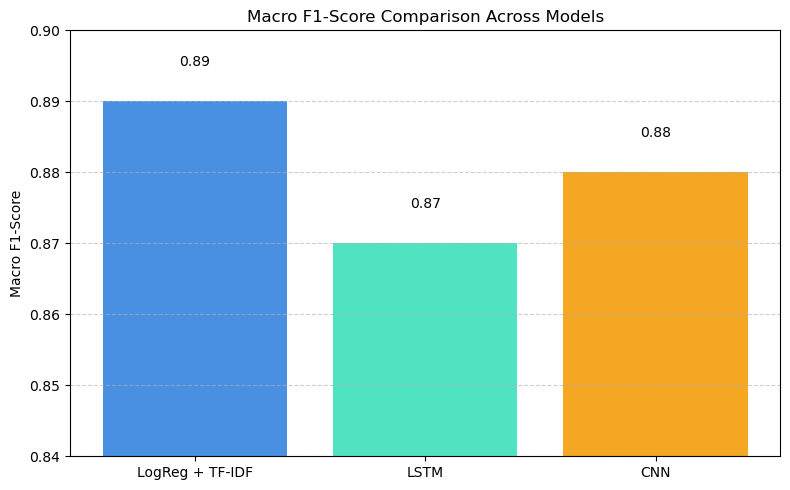

In [29]:
models = ['LogReg + TF-IDF', 'LSTM', 'CNN']
macro_f1 = [0.89, 0.87, 0.88]

# Bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, macro_f1, color = ['#4a90e2', '#50e3c2', '#f5a623'])
plt.title('Macro F1-Score Comparison Across Models')
plt.ylabel('Macro F1-Score')
plt.ylim(0.84, 0.90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()
